In [1]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import os
import networkx as nx
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.cluster import OPTICS
from sklearn.cluster import OPTICS, DBSCAN
from fastnode2vec import Graph, Node2Vec
from sklearn.linear_model import LogisticRegression 
import faiss
import lfr
import embcom
from tqdm import tqdm
import csv

In [ ]:
# Need net, node_table and emb files
# net is G, emb files are wv, node_table probably
# has some info about ground truth community labels or smth like that.

# Define a function that calculates element-centric similarity:
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sparse.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sparse.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected

def find_knn_edges(emb, num_neighbors, 
                   target=None, metric="dotsim",
                   device=None):
    
    k = int(np.minimum(num_neighbors + 1, emb.shape[0]).astype(int))
    indices, distances = find_knn(emb if target is None else target, emb,
                                  num_neighbors=k,
                                  metric=metric,
                                  device=device)
    r = np.outer(np.arange(indices.shape[0]), np.ones((1, indices.shape[1]))).astype(int)
    r, c, distances = (r.reshape(-1),indices.astype(int).reshape(-1),distances.reshape(-1))
    if len(r) == 0:
        return r, c, distances 
    
    return r, c, distances


def find_knn(target, emb, num_neighbors, metric="dotsim", device=None): 
    if metric == "dotsim":
        index = faiss.IndexFlatIP(emb.shape[1]) 
    else:
        index = faiss.IndexFlatL2(emb.shape[1]) 
    
    if device is None:
        index.add(emb.astype(np.float32))
        distances, indices = index.search(target.astype(np.float32), k=num_neighbors)
        # This line takes too long to load.
    else: 
        try:
            gpu_id = int(device[-1])
            res = faiss.StandardGpuResources()
            index = faiss.index_cpu_to_gpu(res, gpu_id, index)
            index.add(emb.astype(np.float32))
            distances, indices = index.search(
                target.astype(np.float32), k=num_neighbors
            )
        except RuntimeError:
            if metric == "dotsim":
                index = faiss.IndexFlatIP(emb.shape[1]) 
            else:
                index = faiss.IndexFlatL2(emb.shape[1])
            
            index.add(emb.astype(np.float32))
            distances, indices = index.search(target.astype(np.float32),
                                              k=num_neighbors)
    return indices, distances

import numba

def louvain(Z, w1, b0, num_neighbors=100, iteration = 50, device = "cuda:0", return_member_matrix=False):
    """"Louvain algorithm for vecto data
    :param Z: embedding
    :type Z: numpy.ndarray
    :param w1: regression coefficient
    :type w1: float
    :param b0: intercept
    :type b0: float
    :param num_neighbors: Number of neighbors, defaults to 100
    :type num_neighbors: int, optional
    :param iteration: The maximum number of iterations, defaults to 50
    :type iteration: int, optional
    :param device: _description_, defaults to "cuda:0"
    :type device: str, optional
    :param return_member_matrix: _description_, defaults to False
    :type return_member_matrix: bool, optional
    :return: _description_
    :rtype: _type_
    """
    # Initialize the intermediate variables
    num_nodes = Z.shape[0]
    node_size = np.ones(num_nodes)
    U = sparse.identity(num_nodes, format="csr")
    Vt = Z.copy()
    
    # The main loop for the Louvain algorithm
    while True:
        # Find the community assignment for the given graph # using a label switching algorithm
        cids_t = label_switching(
               Z=Vt,
               num_neighbors=num_neighbors,
               rho=b0/w1,
               node_size=node_size,
               epochs=iteration,
               device=device,
                )
        
        # This is to make the community labels continuous integer variables
        _, cids_t = np.unique(cids_t, return_inverse=True)
        
        # If no merging, we are good to go out from the loop
        if int(max(cids_t) + 1) == Vt.shape[0]: 
            break
            
        # If two nodes are merged, we created an aggregated network, 
        #where a node represents a community.
        
        num_nodes_t = len(cids_t)
        k = int(np.max(cids_t) + 1)
        Ut = sparse.csr_matrix((np.ones(num_nodes_t), (np.arange(num_nodes_t), cids_t)), shape=(num_nodes_t, k))
        U = U @ Ut
        Vt = Ut.T @ Vt
        
        node_size = np.array(Ut.T @ node_size).reshape(-1)
    if return_member_matrix: 
        return U
    cids = np.array((U @ sparse.diags(np.arange(U.shape[1]))).sum(axis=1)).reshape(-1)

    return cids

#
# Clustering based on a label switching algorithm
#
def label_switching(Z, rho, num_neighbors=50, node_size=None, device=None,epochs=50):
    num_nodes, dim = Z.shape
    if node_size is None:
        node_size = np.ones(num_nodes)
    Z = Z.copy(order="C").astype(np.float32)
    # Construct the candidate graph
    Z1 = np.hstack([Z, np.ones((num_nodes, 1))])
    Zrho = np.hstack([Z, -rho * node_size.reshape((-1, 1))])

    r, c, v = find_knn_edges(
        Zrho,
        target=Z1,
        num_neighbors=num_neighbors,
        metric="cosine",
        device=device)
    A = sparse.csr_matrix((v, (r, c)), shape=(num_nodes, num_nodes))
    
    return _label_switching_(
        A_indptr=A.indptr,
        A_indices=A.indices,
        Z=Z,
        num_nodes=num_nodes,
        rho=rho,
        node_size=node_size,
        epochs=epochs)

#@numba.jit(nopython=True, cache=True)
def _label_switching_(A_indptr, A_indices, Z, num_nodes, rho, node_size,epochs=100):
    Nc = np.zeros(num_nodes)
    cids = np.arange(num_nodes)
    Vc = Z.copy()
    Vnorm = np.sum(np.multiply(Z, Z), axis=1).reshape(-1) 
    for nid in range(num_nodes):
            Nc[nid] += node_size[nid]
    for _it in range(epochs):
        order = np.random.choice(num_nodes, size=num_nodes, replace=False) 
        updated_node_num = 0
        
        for _k, node_id in enumerate(order):
            # Get the weight and normalized weight
            neighbors = A_indices[A_indptr[node_id] : A_indptr[node_id + 1]]

            # Calculate the grain
            c = cids[node_id]
            clist = np.unique(cids[neighbors])
            next_cid = -1
            dqmax = 0
            qself = (
                np.sum(Z[node_id, :] * Vc[c, :])
                - Vnorm[node_id]
                - rho * node_size[node_id] * (Nc[c] - node_size[node_id]))

            for cprime in clist:
                if c == cprime: 
                    continue
                dq = (np.sum(Z[node_id, :] * Vc[cprime, :])
                        - rho * node_size[node_id] * Nc[cprime]) - qself
                if dqmax < dq:
                    next_cid = cprime
                    dqmax = dq
            if dqmax <= 1e-16: 
                continue

            Nc[c] -= node_size[node_id]
            Nc[next_cid] += node_size[node_id]

            Vc[c, :] -= Z[node_id, :]
            Vc[next_cid, :] += Z[node_id, :]

            cids[node_id] = next_cid
            updated_node_num += 1

        if (updated_node_num / np.maximum(1, num_nodes)) < 1e-3: 
            break
    return cids


def get_values(params):
   
    # Normalize the vector of each node to have unit length. This normalization improves clustering.
    X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
    X = emb.copy()
    # Clustering
    kmeans = KMeans(n_clusters= len(set(community_table["community_id"])), random_state=0).fit(X)
    dbscan = DBSCAN().fit(X)
    optics = OPTICS().fit(X)

    
    rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=100, device = "cuda:3")
    cneg = np.random.choice(emb.shape[0], len(cpos))
    vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

    model = LogisticRegression()
    model.fit(
        np.concatenate([vpos, vneg]).reshape((-1, 1)),
        np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
            )
    w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
    gs = louvain(emb, w1, b0, device = "cuda:3")
   
        # Evaluate the clustering
    score_kmeans = calc_esim(community_table["community_id"], kmeans.labels_)
    score_dbscan = calc_esim(community_table["community_id"], dbscan.labels_)
    score_optics = calc_esim(community_table["community_id"], optics.labels_)
    score_proposed = calc_esim(community_table["community_id"], gs) 
     
   # print(f"Element-centric similarity:") 
  #  print(f"K-means: {score_kmeans}")
 #   print(f"DBSCAN: {score_dbscan}") # Something Wrong
#    print(f"OPTICS: {score_optics}") # Something Wrong
#    print(f"Proposed: {score_proposed}")
    print([params['mu'],score_kmeans, score_dbscan, score_optics, score_proposed])
    return [score_kmeans, score_dbscan, score_optics, score_proposed]



# Defaults
params = {
    "N": 100000,     # number of nodes
    "k": 50,       # average degree
    "maxk": 1000,   # maximum degree sqrt(10*N)
    "minc": 50,    # minimum community size
    "maxc": 1000,   # maximum community size sqrt(10*N)
    "tau": 3.0,    # degree exponent
    "tau2": 1.2,   # community size exponent
    "mu": 0.2,     # mixing rate
}

window_length = 10
walk_length = 80 # Standard
num_walks = 10 # Standard
dim = 64

kmeans_values = {}
write_file_path = "mixing_parameter_test.txt"

for mu in tqdm(np.linspace(0,1,21)):
    params['mu'] = mu
    file_name = f"mixing_test_LFR_n_{params['N']}_tau1_{params['tau']}_tau2_{params['tau2']}_mu_{params['mu']}_k_{params['k']}_mincomm_{params['minc']}"
    path_name = "/nobackup/gogandhi/kmeans/data/"
    embedding_name = f"sadamori_node2vec_window_length_{window_length}_dim_{dim}"
    
    # Check if the file exists
    if os.path.isfile(path_name+"net_"+file_name + ".npz"):
            if os.path.isfile(path_name+"community_table_"+file_name+ ".npz"):
                if os.path.isfile(path_name+"emb_"+file_name + embedding_name+ ".npz"):

                    net = sparse.load_npz(path_name+"net_"+file_name + ".npz")
                    community_table = pd.read_csv(path_name+"community_table_"+file_name+ ".npz")
                    emb = np.load(path_name+"emb_"+file_name + embedding_name+ ".npz")['emb']
                    print(params['mu'], " there")
            
    else:
        print(params['mu'], "not there")
        ng = lfr.NetworkGenerator()
        data = ng.generate(**params)

        net = data["net"]                  # scipy.csr_sparse matrix
        community_table = data["community_table"]  # pandas DataFrame
        seed = data["seed"]           # Seed value

        model = embcom.embeddings.Node2Vec(window_length, walk_length, num_walks)
        model.fit(net)
        emb = model.transform(dim=dim)

        file_name = f"mixing_test_LFR_n_{params['N']}_tau1_{params['tau']}_tau2_{params['tau2']}_mu_{params['mu']}_k_{params['k']}_mincomm_{params['minc']}"
        path_name = "/nobackup/gogandhi/kmeans/data/"
        embedding_name = f"sadamori_node2vec_window_length_{window_length}_dim_{dim}"

        sparse.save_npz(path_name+"net_"+file_name + ".npz" ,net) 
        community_table.to_csv(path_name+"community_table_"+file_name+ ".npz",index=False)
        np.savez_compressed(path_name+"emb_"+file_name + embedding_name+ ".npz",emb = emb)

    
    
    kmeans_values[mu] = get_values(params)

    with open(write_file_path, 'a') as file:
        content_to_append = ' '.join(map(str, kmeans_values[mu]))

        # Append the string to the file
        file.write(str(mu) + " " + content_to_append + '\n')  # Add a newline to separate entries
        


# Save the dictionary to a CSV file
with open('mixing_parameter_test.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in kmeans_values.items():
        writer.writerow([key, value])

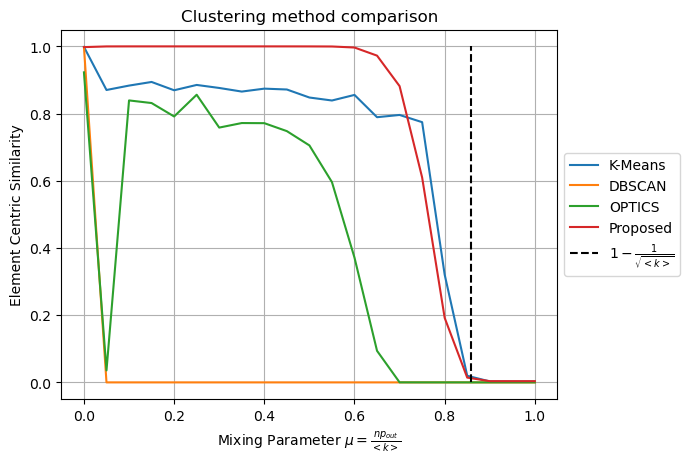

In [31]:
# Load the dictionary from a CSV file
kmeans_values = {}
with open('mixing_parameter_test.txt', 'r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
        values = [float(i) for i in row[0].split(' ')]

        key, scores = values[0],values[1:]
        kmeans_values[key] = scores


# Extract x and y values for each curve
x_values = list(kmeans_values.keys())

# Organize y values for each curve into separate lists
y_values = list(zip(*kmeans_values.values()))

curve_name= {1:"K-Means", 2:"DBSCAN", 3:"OPTICS",4:"Proposed"}
# Create a plot for each curve
for curve_number, y_data in enumerate(y_values, start=1):
    plt.plot(x_values, y_data, label=f'{curve_name[curve_number]}')
plt.vlines(x=1- (1/(50)**0.5), ymin = 0.0, ymax = 1.0, linestyle='dashed', colors = 'k', label=r"$1 - \frac{1}{\sqrt{<k>}}$")
# Customize the plot
plt.xlabel('Mixing Parameter ' + r'$\mu = \frac{np_{out}}{<k>}$')
plt.ylabel('Element Centric Similarity')
plt.title('Clustering method comparison')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))  # Add a legend to differentiate curves
plt.grid(True)

# Show or save the plot
#plt.show()
plt.savefig("mixing_parameter_test.png")

### What fraction of the nodes are being corrected for and how many nodes are we actually getting right?